In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [3]:
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_dir = "../data/MelSpectrograms/"

# Cargamos el dataset
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [4]:
# Vemos las clases que hay con label
classesDataset=dataset.classes
print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'vocal']


In [5]:
print("There are "+str(len(dataset.classes))+" classes")

There are 10 classes


In [6]:
print("Hay "+str(len(dataset))+" imagenes")

Hay 4096 imagenes


In [7]:
# Import y ejecución necesaria para imprimir imagenes
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Label : bass


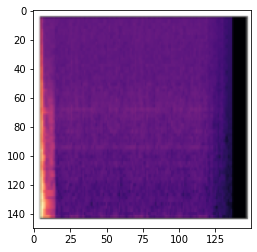

In [8]:
# Mostramos una sola imagen son su label
from matplotlib import pyplot as plt 
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))


display_img(*dataset[0])

In [9]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

# Definimos el batch_size, la cantidad de imagenes que queremos que tenga cada conjunto
batch_size = 32
val_size = 580
test_size = 300
train_size = len(dataset) - (val_size + test_size)

# Asignamos a cada dataset sus imagenes
train_data,val_data,test_data = random_split(dataset,[train_size,val_size,test_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of Test Data : {len(test_data)}")


#Cargamos cada conjunto con sus batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

Length of Train Data : 3216
Length of Validation Data : 580
Length of Test Data : 300


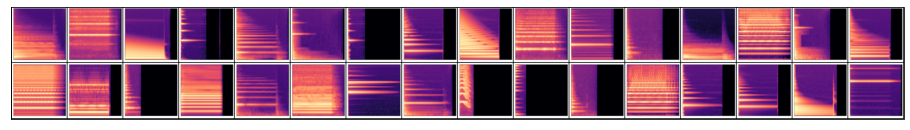

In [10]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Mostramos un batch
def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# Creamos una clase de clasificacion de imagenes para que el modelo pueda hacer uso de esta
class ImageClassificationBase(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.to(device)

    # Definimos el training step
    def training_step(self, batch):
        images, labels = batch[0].to(self.device), batch[1].to(self.device)
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculamos la perdida
        return loss

    # Definimos la validacion del step (definir la entropía para la perdida) para ajustar mejor la accuracy
    def validation_step(self, batch):
        images, labels = batch[0].to(self.device), batch[1].to(self.device)
        out = self(images)  # Generamos las predicciones
        loss = F.cross_entropy(out, labels)  # Calculamos la perdida
        acc = accuracy(out, labels)  # Calculamos la accuracy
        #         self.images=images
        #         self.labels=labels
        return {'val_loss': loss.detach(), 'val_acc': acc}

    # Validacion de la epoca
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Añadimos todas las perdidas de la epoca
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Añadimos todas las accuracy s de la epoca
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # Cada final de epoca mostrar los detalles
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
class ModeloCNN(ImageClassificationBase):
    # Creamos el modelo, con cuantas capas queramos
    #     images=None
    #     labels=None
    def __init__(self, device):
        super().__init__(device)
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(82944, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=1)
        )

    # Devolvemos la topología del modelo
    def forward(self, xb):
        return self.network(xb)

In [13]:
# Definimos nuestra propia funcion para evaluar la accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor((torch.sum(preds == labels).item() / len(preds))) # Contamos la cantidad de predicciones que ha acertado y lo dividimos entre el numero de predicciones hechas

# Evaluamos el modelo para 1 batch
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval() # Método de pytorch
    outputs = [model.validation_step(batch) for batch in val_loader] # Aquí tendremos los outputs de cada trainig step
    #     print(outputs)
    return model.validation_epoch_end(outputs) # Aquí tendremos los outputs del final de la epoca

# Definimos el fit para nuestros datos al modelo
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = [] # Creamos una lista para llevar una "memoria" de cada epoca
    optimizer = opt_func(model.parameters(), lr) # Definimos el optimizador
    for epoch in range(epochs):

        model.train() # Método de pytorch para entrenar el modelo cada época
        train_losses = [] # Lista para poder ir añadiendo las pérdidas al modelo

        for batch in train_loader: # Evaluamos todas las imagenes del dataset de entrenamiento
            loss = model.training_step(batch) # Entrenamos un paso y le pasamos un batch de imagenes
            train_losses.append(loss) # Añadimos las pérdidas
            loss.backward() # Método de pytorch donde pretende analizar dloss/dx para cada parametro x
            optimizer.step() # Método de pytorch para actualizar los parametros
            optimizer.zero_grad() # Método de pytorch que setea los gradientes de todos los tensores optimizados a 0

        # Evaluamos los datos y añadimos las pérdidas de la epoca
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        
        # Recopilamos los datos de la epoca y los añadimos al historial
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [16]:
#No ejectutar si vamos a cargar el modelo
num_epochs = 7 # Numero de épocas de entrenamiento del modelo
opt_func = torch.optim.Adam # Definimos el optimizador
lr = 0.001 # Definimos el learning rate

model = ModeloCNN().to(device) # Ajustamos nuestro modelo al device que tengamos disponible

# Summary del modelo

In [17]:
# Mostramos el detalle del modelo
summary(model,(3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             896
              ReLU-2         [-1, 32, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          18,496
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [18]:
# Mostramos el historial de entrenamiento del modelo
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.5956, val_loss: 1.3029, val_acc: 0.5250
Epoch [1], train_loss: 0.7213, val_loss: 0.4183, val_acc: 0.8625
Epoch [2], train_loss: 0.3133, val_loss: 0.2190, val_acc: 0.9234
Epoch [3], train_loss: 0.1755, val_loss: 0.1391, val_acc: 0.9641
Epoch [4], train_loss: 0.1053, val_loss: 0.1748, val_acc: 0.9672
Epoch [5], train_loss: 0.0872, val_loss: 0.1925, val_acc: 0.9453
Epoch [6], train_loss: 0.0668, val_loss: 0.0933, val_acc: 0.9828


In [20]:
# Definimos una ruta para almacenar/cargar el modelo
miRutaRelativa = "./trainedModelNoHistory.pth"

# Guardamos el modelo
torch.save(model.state_dict(),miRutaRelativa)

In [15]:
# Simulamos que cargamos el modelo
device = torch.device('cpu')
model = ModeloCNN()
model.load_state_dict(torch.load(miRutaRelativa, map_location=device))

<All keys matched successfully>

# Hacemos un test

In [18]:
test_dlPrueba=DataLoader(test_data, 1, num_workers = 4, pin_memory = True)
contador=0
contadorAciertos=0
indiceReal=None
for batch in test_dlPrueba:
    indiceReal=batch[1][0].item()
    indicePredicho=predict(model,batch[0].to(device))
    if(indiceReal==indicePredicho):
        contadorAciertos+=1
    contador+=1
print("Contador: "+str(contador))
print("Contador Aciertos: "+str(contadorAciertos))
print("Contador Aciertos %: "+str(contadorAciertos/contador*100))

Contador: 300
Contador Aciertos: 285
Contador Aciertos %: 95.0
